<a href="https://colab.research.google.com/github/MichaelReh/testingSGppNotebooks/blob/master/Interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use the `Open in Colab' button to execute this notebook in Google Colab.
No local installation of $SG^{++}$ is required. 

The following illustrates how you can install the latest version of $SG^{++}$ in a Colab instance. However, for this tutorial we offer a precompiled version, so you can ignore this code block

In [0]:
## -*- coding: utf-8 -*-
#! apt-get install scons swig # build tools for sgpp
#! git clone https://github.com/SGpp/SGpp.git
#! cd SGpp 
#
## install sgpp -- start early, takes > 30min!
#!cd SGpp  && scons -j4 SG_BASE=1 SG_COMBIGRID=1 SG_DATADRIVEN=1 SG_MISC=0 SG_OPTIMIZATION=1 SG_PDE=1 SG_QUADRATURE=1 SG_SOLVER=1 SG_JAVA=0 SG_MATLAB=0 SG_PYTHON=1 COMPILE_BOOST_TESTS=0 RUN_BOOST_TESTS=0
#
#import sys
#import os
#
#sgpp_folder = "SGpp"
#
## Make python interface available
#if not 'moduleDir' in globals():
#    moduleDir = os.path.join(os.path.join(os.getcwd(), sgpp_folder),"lib")
#    pysgpp_path = os.path.join(os.path.join(os.getcwd(), sgpp_folder),"lib/pysgpp")
#    sys.path.append(moduleDir)
#    sys.path.append(pysgpp_path)
#
#sgpp_path = os.path.join(os.path.join(os.getcwd(), sgpp_folder),"lib/sgpp")
#
## do file fiddling necessary in colab so everything is found
#!sed -ie 's/^\(from . import extensions\)/try:\n    \1\nexcept:\n    import extensions/' $pysgpp_path/__init__.py
#!cp $sgpp_path/* /usr/lib

Download the precompiled $SG^{++}$, unzip and set python paths

In [0]:
! wget https://ipvs.informatik.uni-stuttgart.de/cloud/s/xwRLygmKQ5HzRJK/download

In [0]:
! mv download SGpp.zip
! unzip SGpp.zip

In [0]:
import sys
import os
sgpp_folder = "SGpp"

# Make python interface available
if not 'moduleDir' in globals():
    moduleDir = os.path.join(os.path.join(os.getcwd(), sgpp_folder),"lib")
    pysgpp_path = os.path.join(os.path.join(os.getcwd(), sgpp_folder),"lib/pysgpp")
    sys.path.append(moduleDir)
    sys.path.append(pysgpp_path)

sgpp_path = os.path.join(os.path.join(os.getcwd(), sgpp_folder),"lib/sgpp")
# copy shared libs to where we're looking for libraries
!cp $sgpp_path/* /usr/lib

# Interpolation

This notebook demonstrates the very basic usage of $SG^{++}$.
It shows:
- how to interpolate a function with a regular sparse grid and different types of basis functions
- how to refine a grid spatially adaptive
- how to integrate the interpolant

Note: If you want to run these introductory notebooks interactively in your browser, you can use Google Colab. See [the according Wiki page](https://github.com/SGpp/SGpp/wiki/Installing-pysgpp-on-colab) for more instructions.

Import the necessary modules. The python bindings for $SG^{++}$ are called "pysgpp".

In [0]:
%matplotlib notebook
%matplotlib inline
from __future__ import print_function
from pysgpp import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

Define a simple objective function  
$f: \Omega:=[0,1]^2\to\mathbb{R}$,  
$[x_1,x_2]\mapsto 16x_1(1-x_1^2)x_2(1-x_2^2)$ 
  
Note: By default $SG^{++}$ defines grids on $[0,1]^{D}$.

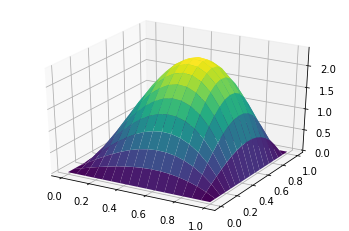

In [5]:
def f(x1, x2):
    return 16*x1*(1-x1**2)*x2*(1-x2**2)
# and plot
XX = np.linspace(0,1,17)
(X, Y) = np.meshgrid(XX, XX)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, f(X, Y), rstride=1, cstride=1, cmap='viridis')

### Grid Creation
Create a regular sparse grid. The Type of basis functions is determined by this call, for example  
- `createLinearGrid`, creates a nonboundary sparse grid with linear basis functions ("hat functions")
- `createLinearBoundaryGrid`, creates a boundary sparse grid with linear basis functions ("hat functions")  
- `createPolyGrid`, creates a nonboundary sparse grid with polynomial basis functions  
- ... many more (39 with more to come) see class `GridType` in Grid.hpp for the complete list.

In [0]:
dim = 2
grid = Grid.createLinearGrid(dim)
# grid = Grid.createLinearBoundaryGrid(dim)
# grid = Grid.createPolyGrid(dim, 3)
level = 3
gridGen = grid.getGenerator()
gridGen.regular(level)

Separation of concerns:
GridStorage object allows to provide different implementations

In [7]:
gridStorage = grid.getStorage()
print("Dim    =", gridStorage.getDimension())
print("|grid| =", gridStorage.getSize())

Dim    = 2
|grid| = 17


### Plotting

Plot the sparse grid by obtaining its coordinates from the gridStorage object.

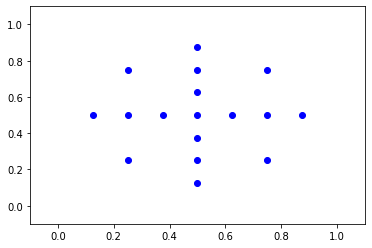

In [8]:
coords = np.zeros((gridStorage.getSize(),dim))
for i in range(gridStorage.getSize()):
    gp = gridStorage.getPoint(i)
    coords[i] = np.array([gp.getStandardCoordinate(0), gp.getStandardCoordinate(1)])
fig = plt.figure()
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.plot(coords[:,0], coords[:,1], 'ob')

### Hierarchize
In the context of sparse grids, the calculation of the interpolation coefficients is called "hierarchization". The hierarchization require evaluations of the objective function at the grid points.  
SG++ uses a wrapper for `std::vector<double>`, called `DataVector`. Create such a DataVector `alpha` and use it to store the function evaluations. To do so, loop over the gridStorage object, and evaluate the objective function in each grid point `gp`.

In [9]:
alpha = DataVector(gridStorage.getSize())
for i in range(gridStorage.getSize()):
    gp = gridStorage.getPoint(i)
    alpha[i] = f(gp.getStandardCoordinate(0), gp.getStandardCoordinate(1))
print(alpha)

[2.25000000000000000000e+00, 1.40625000000000000000e+00, 1.96875000000000000000e+00, 7.38281250000000000000e-01, 1.93359375000000000000e+00, 2.28515625000000000000e+00, 1.23046875000000000000e+00, 1.40625000000000000000e+00, 1.96875000000000000000e+00, 7.38281250000000000000e-01, 1.93359375000000000000e+00, 2.28515625000000000000e+00, 1.23046875000000000000e+00, 8.78906250000000000000e-01, 1.23046875000000000000e+00, 1.23046875000000000000e+00, 1.72265625000000000000e+00]


The second step of hierarchization is the actual calculation of the interpolation coefficients. In the context of sparse grids, these coefficients are often called "surpluses". SG++ provides a factory method, which chooses the best available hierarchization implementation for the given grid.

Note: OperationHierarchisation is not implemented for all basis functions. The example notebook Optimization.ipynb demonstrates how to manually hierarchize by explicitly creating the interpolation SLE and selecting an external library to solve it.

In [10]:
opHier = createOperationHierarchisation(grid)
opHier.doHierarchisation(alpha)
print(alpha)

[2.25000000000000000000e+00, 2.81250000000000000000e-01, 8.43750000000000000000e-01, 3.51562500000000000000e-02, 1.05468750000000000000e-01, 1.75781250000000000000e-01, 2.46093750000000000000e-01, 2.81250000000000000000e-01, 8.43750000000000000000e-01, 3.51562500000000000000e-02, 1.05468750000000000000e-01, 1.75781250000000000000e-01, 2.46093750000000000000e-01, 3.51562500000000000000e-02, 1.05468750000000000000e-01, 1.05468750000000000000e-01, 3.16406250000000000000e-01]


### Evaluate
Create an OperationEval, which automatically determines the type of basis functions used and evaluates the interpolant as linear combination of these basis functions and the coefficients `alpha`. Demonstrate by evaluating an arbitrary point `p`.

In [11]:
opEval = createOperationEval(grid)
p = DataVector([0.3, 0.3])
evaluation = opEval.eval(alpha, p)
print('interpolant evaluation:',evaluation)
print('function evaluation   :',f(p[0],p[1]))

interpolant evaluation: 1.153125
function evaluation   : 1.192464


## Plot the interpolant

Create a 'DataMatrix' to store the (x,y) coordinates of the plot. Use an 'OperationMultipleEval', to evaluate the interpolant in all these coordinates at once. Cast the vector of evaluations 'z' into a python array 'res' and plot it.

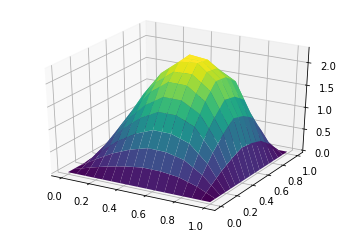

In [12]:
xy = DataMatrix(list(zip(X.flatten(), Y.flatten())))
z = DataVector(xy.getNrows())
opMEval = createOperationMultipleEval(grid, xy)
opMEval.mult(alpha, z)
res = z.array()
res = res.reshape((len(X), len(X[0])))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, res, rstride=1, cstride=1, cmap='viridis')

### Adaptive Refinement
One of the main features of SG++ is the spatially adaptive creation of sparse grids. Different refinement criteria are implemented and can be used. They criteria are implemented as derivations from RefinementFunctor.  
Here we use surplus refinement, the standard and most common refinement criterion. It selects the `refinements_num` grid points, which have the largest surpluses. This criterion is motivated by the hierarchical basis and aims to minimize the L2 error of the approximation. Once the criterion has selected the grid points that will be refined, the `refine` routine adds all their hierarchical children to the grid.

In [13]:
N_old = gridStorage.getSize()
refinements_num = 1
gridGen.refine(SurplusRefinementFunctor(alpha, refinements_num))
N = gridStorage.getSize()
print(N_old, "->", N)

17 -> 21


Plot the spatially refined sparse grid.

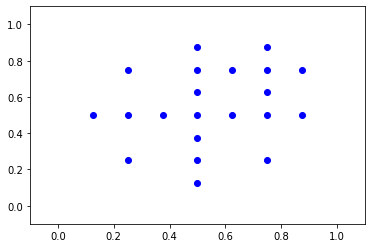

In [14]:
coords = np.zeros((gridStorage.getSize(),dim))
for i in range(gridStorage.getSize()):
    gp = gridStorage.getPoint(i)
    coords[i] = np.array([gp.getStandardCoordinate(0), gp.getStandardCoordinate(1)])
fig = plt.figure()
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.plot(coords[:,0], coords[:,1], 'ob')

After the grid has been refined, the new surpluses must be calculated

In [15]:
alpha.resizeZero(N)
for i in range(N):
    gp = gridStorage.getPoint(i)
    alpha[i] = f(gp.getStandardCoordinate(0), gp.getStandardCoordinate(1))
opHier = createOperationHierarchisation(grid)
opHier.doHierarchisation(alpha)
print(alpha)

[2.25000000000000000000e+00, 2.81250000000000000000e-01, 8.43750000000000000000e-01, 3.51562500000000000000e-02, 1.05468750000000000000e-01, 1.75781250000000000000e-01, 2.46093750000000000000e-01, 2.81250000000000000000e-01, 8.43750000000000000000e-01, 3.51562500000000000000e-02, 1.05468750000000000000e-01, 1.75781250000000000000e-01, 2.46093750000000000000e-01, 3.51562500000000000000e-02, 1.05468750000000000000e-01, 1.05468750000000000000e-01, 3.16406250000000000000e-01, 6.59179687500000000000e-02, 9.22851562500000000000e-02, 6.59179687500000000000e-02, 
9.22851562500000000000e-02]


Plot the new interpolant.

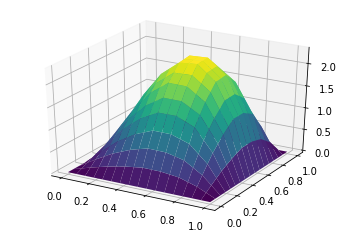

In [16]:
opMEval.mult(alpha, z)
res = z.array()
res = res.reshape((len(X), len(X[0])))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, res, rstride=1, cstride=1, cmap='viridis')

### Quadrature
With the grid object and the according surpluses `alpha` at hand, an `OperationQuadrature` can be used to calculate the integral.

In [17]:
opQ = createOperationQuadrature(grid)
integral = opQ.doQuadrature(alpha)
print('integral:', integral)

integral: 0.9591064453125
